In [1]:
import math
import numpy as np
import pandas as pd
import os
import tempfile

from scipy.spatial.distance import pdist, squareform
import scipy.io as sio

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
trainPredict = np.load('trainPredict.npy')
train_result = np.sum(trainPredict, axis=1)
testPredict = np.load('testPredict.npy')
test_result = np.sum(testPredict, axis=1)

##  Get distributions of Dest by Source,Time

In [3]:
orderdf = pd.read_csv('ignored_assets/orders.csv', parse_dates = [6])

In [4]:
# Create map of driver IDs
driver_ids=orderdf['driver_id'].unique()

# create map of core stations
core_stations = orderdf['start_district_hash'].unique()
core_stations.sort()

#Index stuff
orderdf_f=orderdf[(~pd.isnull(orderdf['driver_id'])) & orderdf['dest_district_hash'].isin(core_stations)]
myindex=pd.MultiIndex.from_arrays([orderdf_f['driver_id'],orderdf_f['timestamp']],names=('driver_id','timestamp'))

orderdf2=orderdf_f.set_index(myindex)
orderdf_s=orderdf2.sort_index()

orderdf_s['time_bucket'] = orderdf_s['timestamp'].dt.round('5min')
orderdf_s['pax_arrival_time'] = orderdf_s['timestamp'] + orderdf_s['expected_travel_time'] * pd.Timedelta('1 minute')
orderdf_s['time_bucket_arrival'] = orderdf_s['pax_arrival_time'].dt.round('5min')

In [5]:
stepsize = pd.Timedelta('5 min')
horizon = pd.Timedelta('2 hour')
start = pd.to_datetime('2016-01-20 00:00:00')
end = pd.to_datetime('2016-01-21 00:00:00')

In [6]:
mask = (orderdf_s['time_bucket'] >= start) & (orderdf_s['time_bucket'] < end)

In [7]:
dates = [start + j*stepsize for j in range(int(horizon / stepsize))]
iterables = [dates, core_stations]
mindex = pd.MultiIndex.from_product(iterables, names=['time_bucket', 'start_district_hash'])
mcolumns = pd.MultiIndex.from_arrays([core_stations], names=['dest_district_hash'])

In [8]:
base = pd.DataFrame(index=mindex, columns=mcolumns).fillna(0)

In [9]:
pt = (base + pd.pivot_table(orderdf_s[mask], index=['time_bucket','start_district_hash'], 
               columns=['dest_district_hash'], aggfunc=len, 
               values='order_id', fill_value=0)).fillna(0)

In [10]:
prior = pd.pivot_table(orderdf_s, index=['start_district_hash'], 
               columns=['dest_district_hash'], aggfunc=len, 
               values='order_id', fill_value=0)

In [11]:
#weight of the prior (based on hours and days of samples)
ndays = 20.
nhours = 24.
w = 1 / (ndays * nhours)

# sum both
count = pt + w*prior

# get posterior
posterior = count.div( count.sum(axis=1), axis = 0).fillna(0)

In [12]:
posterior.head()

dest_district_hash                            08232402614a9b48895cc3d0aeb0e9f2  \
time_bucket start_district_hash                                                  
2016-01-20  08232402614a9b48895cc3d0aeb0e9f2                          0.123467   
            08f5b445ec6b29deba62e6fd8b0325a6                          0.000000   
            0a5fef95db34383403d11cb6af937309                          0.000000   
            1afd7afbc81ecc1b13886a569d869e8a                          0.000038   
            1c60154546102e6525f68cb4f31e0657                          0.000000   

dest_district_hash                            08f5b445ec6b29deba62e6fd8b0325a6  \
time_bucket start_district_hash                                                  
2016-01-20  08232402614a9b48895cc3d0aeb0e9f2                          0.000000   
            08f5b445ec6b29deba62e6fd8b0325a6                          0.042336   
            0a5fef95db34383403d11cb6af937309                          0.000000   
            1afd7afbc81ecc1b13886a569d869e8a                          0.001509   
            1c60154546102e6525f68cb4f31e0657                          0.000000   

dest_district_hash                            0a5fef95db34383403d11cb6af937309  \
time_bucket start_district_hash                                                  
2016-01-20  08232402614a9b48895cc3d0aeb0e9f2                          0.000000   
            08f5b445ec6b29deba62e6fd8b0325a6                          0.000000   
            0a5fef95db34383403d11cb6af937309                          0.548872   
            1afd7afbc81ecc1b13886a569d869e8a                          0.000023   
            1c60154546102e6525f68cb4f31e0657                          0.000087   

dest_district_hash                            1afd7afbc81ecc1b13886a569d869e8a  \
time_bucket start_district_hash                                                  
2016-01-20  08232402614a9b48895cc3d0aeb0e9f2                          0.001635   
            08f5b445ec6b29deba62e6fd8b0325a6                          0.090235   
            0a5fef95db34383403d11cb6af937309                          0.000000   
            1afd7afbc81ecc1b13886a569d869e8a                          0.332601   
            1c60154546102e6525f68cb4f31e0657                          0.000346   

dest_district_hash                            1c60154546102e6525f68cb4f31e0657  \
time_bucket start_district_hash                                                  
2016-01-20  08232402614a9b48895cc3d0aeb0e9f2                          0.000000   
            08f5b445ec6b29deba62e6fd8b0325a6                          0.000000   
            0a5fef95db34383403d11cb6af937309                          0.000000   
            1afd7afbc81ecc1b13886a569d869e8a                          0.000034   
            1c60154546102e6525f68cb4f31e0657                          0.022684   

dest_district_hash                            1cbfbdd079ef93e74405c53fcfff8567  \
time_bucket start_district_hash                                                  
2016-01-20  08232402614a9b48895cc3d0aeb0e9f2                          0.000818   
            08f5b445ec6b29deba62e6fd8b0325a6                          0.000618   
            0a5fef95db34383403d11cb6af937309                          0.007519   
            1afd7afbc81ecc1b13886a569d869e8a                          0.000625   
            1c60154546102e6525f68cb4f31e0657                          0.000087   

dest_district_hash                            1ecbb52d73c522f184a6fc53128b1ea1  \
time_bucket start_district_hash                                                  
2016-01-20  08232402614a9b48895cc3d0aeb0e9f2                          0.000000   
            08f5b445ec6b29deba62e6fd8b0325a6                          0.000000   
            0a5fef95db34383403d11cb6af937309                          0.000000   
            1afd7afbc81ecc1b13886a569d869e8a                          0.000015   
            1c60154546102e6525f68cb4f31e0657              

In [465]:
Y = np.load('ignored_assets/Y.npy')
Y_total = np.sum(Y,axis=1)
num = Y.shape[0]

In [304]:
start2 = pd.to_datetime('2016-01-21 00:00:00')
end2 = pd.to_datetime('2016-01-22 00:00:00')
mask2 = (orderdf_s['time_bucket'] >= start2) & (orderdf_s['time_bucket'] < end2)

In [305]:
ptable = pd.pivot_table(orderdf_s[mask2], index='time_bucket', 
               columns=['start_district_hash'], aggfunc=len, 
               values='order_id', fill_value=0).fillna(0)

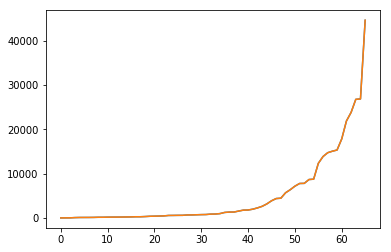

In [496]:
order = Y[-288:].sum(axis=0).argsort()
cols = ptable.as_matrix().sum(axis=0).argsort()
plt.plot(Y[-288:].sum(axis=0)[order])
plt.plot(ptable.as_matrix().sum(axis=0)[cols])

In [497]:
cols

array([ 2, 58, 44, 19,  0, 37,  1, 33, 16, 60, 27, 35, 22, 34, 57, 32, 54,
       65, 21,  4, 39, 52, 29, 45, 30,  8, 50, 15, 51, 25,  6, 11, 63, 23,
        7, 49,  5, 20, 62, 55, 24, 61, 17, 59, 48, 38, 14, 26, 47, 43, 53,
       13, 64, 12, 10, 31,  3, 41, 42, 46, 40, 28,  9, 36, 18, 56])

In [498]:
order.argsort()

array([60, 41, 10, 48, 18, 36, 58, 63, 44, 12, 43, 55, 37, 54,  1, 31, 23,
       25, 49, 57, 53, 45, 64, 51, 46, 47, 52, 62, 40, 11, 34, 17, 29, 20,
       42, 39, 59, 33, 22, 24, 32, 50,  6,  5, 21, 56, 27, 61, 15,  4, 65,
        7, 38, 28,  8, 19, 35, 16, 14,  3,  9,  2,  0, 26, 13, 30])

In [499]:
order

array([62, 14, 61, 59, 49, 43, 42, 51, 54, 60,  2, 29,  9, 64, 58, 48, 57,
       31,  4, 55, 33, 44, 38, 16, 39, 17, 63, 46, 53, 32, 65, 15, 40, 37,
       30, 56,  5, 12, 52, 35, 28,  1, 34, 10,  8, 21, 24, 25,  3, 18, 41,
       23, 26, 20, 13, 11, 45, 19,  6, 36,  0, 47, 27,  7, 22, 50])

In [500]:
sorted_cols = ptable.columns[cols]

named_cols = sorted_cols[order.argsort()]

In [501]:
lastDayPrediction = pd.DataFrame(trainPredict[-288:].clip(min=0).round(), 
                                 columns = named_cols,
                                 index = ptable.index - pd.Timedelta('1 day')
                                )

In [502]:
lastDayPrediction.head()

start_district_hash,90c5a34f06ac86aee0fd70e2adce7d8a,f2c8c4bb99e6377d21de71275afd6cd2,58c7a4888306d8ff3a641d1c0feccbe3,b26a240205c852804ff8758628c0a86a,4b9e4cf2fbdc8281b8a1f9f12b80ce4d,1cbfbdd079ef93e74405c53fcfff8567,929ec6c160e6f52c20a4217c7978f681,82cc4851f9e4faa4e54309f8bb73fd7c,b702e920dcd2765e624dc1ce3a770512,4f4041f7db0c7f69892d9b74c1a7efa1,...,ba32abfc048219e933bee869741da911,cb6041cc08444746caf6039d8b9e43cb,d524868ce69cb9db10fc5af177fb9423,49ac89aa860c27e26c0836cb8dab2df2,de092beab9305613aca8f79d7d7224e7,a735449c5c09df639c35a7d61fad3ee5,0a5fef95db34383403d11cb6af937309,bf44d327f0232325c6d5280926d7b37d,825a21aa308dea206adb49c4b77c7805,1ecbb52d73c522f184a6fc53128b1ea1
time_bucket,,,,,,,,,,,,,,,,,,,,,
2016-01-20 00:00:00,28.0,2.0,0.0,7.0,0.0,1.0,24.0,35.0,5.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2016-01-20 00:05:00,27.0,2.0,0.0,7.0,0.0,1.0,21.0,33.0,4.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2016-01-20 00:10:00,24.0,2.0,0.0,6.0,0.0,1.0,23.0,32.0,4.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2016-01-20 00:15:00,23.0,1.0,0.0,5.0,0.0,1.0,21.0,31.0,4.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2016-01-20 00:20:00,21.0,1.0,0.0,5.0,0.0,1.0,19.0,29.0,3.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


reshape s.t. MultiIndex match

In [503]:
ldp_series = lastDayPrediction.stack()

In [504]:
prediction = posterior.multiply(ldp_series, axis='index').fillna(0).round()

In [507]:
ldp_series.sum()

280294.0

In [556]:
pt_pred = prediction.sum(axis=1).unstack()

In [550]:
lastDayPrediction.sum(axis=0).argmax()

'd4ec2125aff74eded207d2d915ef682f'

In [551]:
ptable.sum(axis=0).argmax()

'd4ec2125aff74eded207d2d915ef682f'

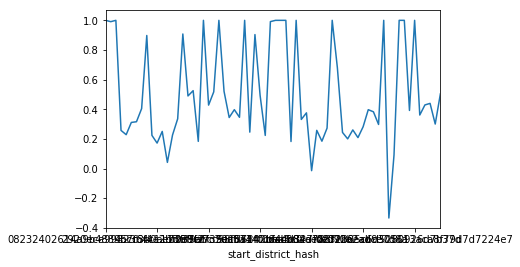

In [560]:
realtot = ptable.sum(axis=0)
misspred = (realtot - pt_pred.sum(axis=0)).divide(realtot)
misspred.plot()

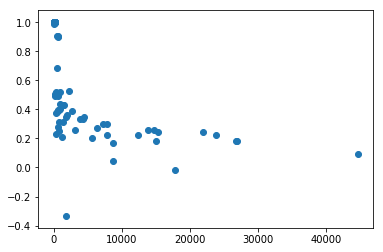

In [561]:
plt.scatter(realtot,misspred)

The prediction is not necessarily good for low demand stations. Which is _ok_

# convert to  input files!

In [562]:
FlowsOut = prediction.sum(axis=1)

In [563]:
FlowsOut.sum()

260780.0

In [603]:
flowsout = FlowsOut.unstack()[core_stations]

In [605]:
print 'demand lost due to round-off: ', (FlowsOut.sum() -ldp_series.sum())/ ldp_series.sum()

demand lost due to round-off:  -0.0696197563986


In [606]:
nsteps = int(pd.Timedelta('1 day') / stepsize)

In [607]:
stepsize = pd.Timedelta('5 min')
horizon = pd.Timedelta('2 hour')
start = pd.to_datetime('2016-01-21 00:00:00')

### The difficult one is the flowsin

True


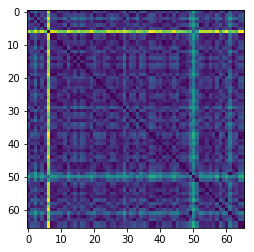

In [617]:
station_locations = pd.read_csv('inferred_locations.csv')
D = np.ceil(squareform(pdist(station_locations[['x','y']].as_matrix())) / 5.)
np.fill_diagonal(D, 1.)
stations = list(station_locations['start_district_hash'])
print stations == list(core_stations)
plt.imshow(D)

In [692]:
travel_times = pd.DataFrame(D)
travel_times.columns = core_stations
travel_times.index = core_stations
travel_times = travel_times * pd.Timedelta('5 min')

In [693]:
a = start + travel_times.loc['08232402614a9b48895cc3d0aeb0e9f2'] - pd.Timedelta('1 day')
b = core_stations

In [697]:
# fuck this, we're doing it slow
#begin = start
#end = begin + horizon
#dts = [begin + j*stepsize for j in range(int(horizon / stepsize))]
#mindex = pd.MultiIndex.from_product([dts,core_stations])
#base = pd.DataFrame(
#        start,
#        index=mindex,
#        columns = core_stations
#    )

In [723]:
start = pd.to_datetime('2016-01-20 00:00:00')

In [724]:
# FlowsOut.unstack().loc[start:end - pd.Timedelta('10 hour')]

In [763]:
begin

Timestamp('2016-01-20 00:00:00')

In [780]:
def estimate_arrival(series):
    arrival_time = series['time_bucket'] + travel_times['start_district_hash']['dest_district_hash']
    return arrival_time

In [788]:
test = prediction.T.unstack().reset_index()
test = test[test[0] > 0]

In [802]:
test['arrival_time'] = test['time_bucket'] + travel_times.lookup(test['start_district_hash'], test['dest_district_hash'])

In [856]:
flowsout = np.zeros((nsteps,), dtype=np.object)
flowsin = np.zeros((nsteps,), dtype=np.object)
columns = core_stations
for i in range(nsteps):
    t0 = time.time()
    begin = start + i*stepsize
    end = begin + horizon
    index = [begin + j*stepsize for j in range(int(horizon / stepsize))]
    base = pd.DataFrame(
        np.zeros((len(index),len(columns)),dtype=np.float64),
        index=index,
        columns = columns
    )
    mask = (test['time_bucket'] >  begin) & (test['time_bucket'] <=  end)
    
    if np.sum(mask) > 0:
        flowsout[i] = (base + pd.pivot_table(test[mask], index='time_bucket', 
               columns=['start_district_hash'], aggfunc=np.sum, 
               values=0, fill_value=0)).fillna(0).as_matrix()
    else:
        flowsout[i] = base.fillna(0).as_matrix()
    
    # ok efficiency
    
    if np.sum(mask) > 0:
        flowsin[i] = (base + pd.pivot_table(test[mask], index='arrival_time', 
               columns=['dest_district_hash'], aggfunc=np.sum, 
               values=0, fill_value=0)).fillna(0).as_matrix()
    else:
        flowsin[i] = base.fillna(0).as_matrix()

In [859]:
flowsout[-1].shape

(24, 66)

In [860]:
predictions  ={
        'FlowsIn': flowsin,
        'FlowsOut': flowsout
    }

In [861]:
sio.savemat('lstm_predictions.mat',predictions)

In [863]:
flowsin[0]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  9.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [864]:
perfect = sio.loadmat('perfect_predictions.mat')

In [891]:
np.abs(perfect['FlowsOut'][0][0].sum() - flowsout[0].sum())

1511.0

In [ ]:
ierrs = []
oerrs =[]

for i in range(288):
    inerr  = (perfect['FlowsOut'][0][i].sum() - flowsout[i].sum()) / perfect['FlowsOut'][0][i].sum()
    ouerr = (perfect['FlowsIn'][0][i].sum() - flowsin[i].sum()) / perfect['FlowsIn'][0][i].sum()
    ierrs.append(inerr)
    oerrs.append(ouerr)

In [ ]:
plt.plot(ierrs)
plt.plot(oerrs)